# Import packages and loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns

In [2]:
import warnings 
warnings.filterwarnings('ignore')

# Data processing

## Checking the missing value

In [3]:
#Load the in sample csv file
train = pd.read_csv('UnemploymentRate_InSample.csv')

#Load the out of sample csv file
test = pd.read_csv('UmemploymentRate_OutofSample.csv')

In [4]:
print('training data dimensions: ',np.shape(train))
print('test data dimensions: ',np.shape(test))

training data dimensions:  (479, 2)
test data dimensions:  (24, 2)


In [5]:
train.isna().sum().sort_values(ascending=False)

Date                 0
Unemployment_Rate    0
dtype: int64

In [6]:
test.isna().sum().sort_values(ascending=False)

Date                 0
Unemployment_Rate    0
dtype: int64

# Feature engineering 

In [7]:
#Convert argument to datetime
train['Date'] = pd.to_datetime(train['Date'], format = '%b-%y')
train.set_index('Date',inplace = True)

train

,Unemployment_Rate
Date,
1978-02-01,7.5
1978-03-01,6.6
1978-04-01,6.2
1978-05-01,6.2
1978-06-01,6.1
...,...
2017-08-01,5.5
2017-09-01,5.3
2017-10-01,5.1


In [8]:
#Convert argument to datetime
test['Date'] = pd.to_datetime(test['Date'], format = '%b-%y')
test.set_index('Date',inplace = True)
test

,Unemployment_Rate
Date,
2018-01-01,6.0
2018-02-01,6.0
2018-03-01,5.9
2018-04-01,5.6
2018-05-01,5.3
2018-06-01,5.2
2018-07-01,5.2
2018-08-01,5.3
2018-09-01,4.9


# Exploratory Data Analysis

## Basic analysis

### Descriptive statistics

In [9]:
train.describe().round(4)

,Unemployment_Rate
count,479.0000
mean,6.8877
std,1.7886
min,3.9000
25%,5.6000
50%,6.4000
75%,8.1000
max,12.1000


In [10]:
kurtosis = train['Unemployment_Rate'].kurt().round(4)
kurtosis

-0.3067

In [11]:
skewness = train['Unemployment_Rate'].skew().round(4)
skewness

0.6998

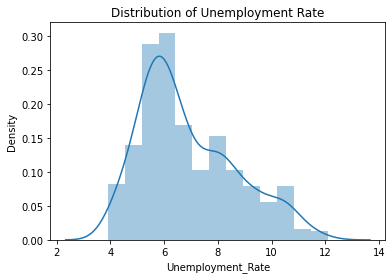

In [12]:

sns.distplot(train['Unemployment_Rate'])
plt.title('Distribution of Unemployment Rate')
plt.show('without log')

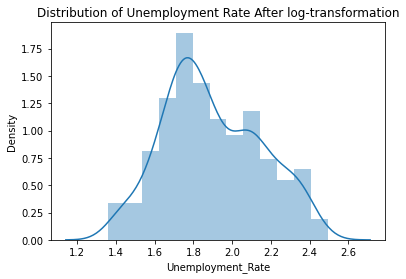

In [13]:
#log-transformation on y
train_log=np.log(train['Unemployment_Rate'])
sns.distplot(train_log)
plt.title('Distribution of Unemployment Rate After log-transformation')
plt.savefig('with log')

### Time series plot

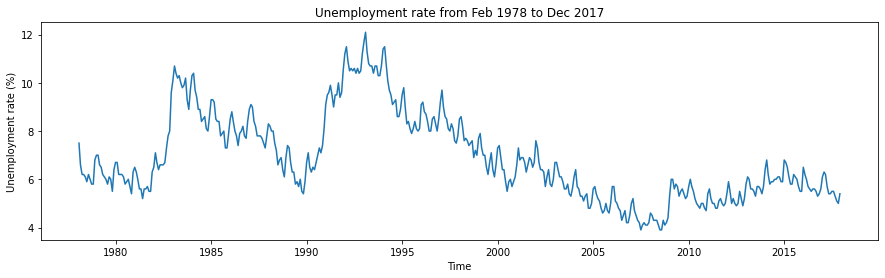

In [14]:
plt.figure(figsize = (15,4))
plt.plot(train)
plt.title('Unemployment rate from Feb 1978 to Dec 2017')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.savefig('time series')

## Moving average smoothing

In [15]:
# Define a rolling object with window size (MA order) MA-3 and MA-12, respectively
# and then call mean() to get the average of the moving windows
train_CMA3 = train.rolling(3,center=True).mean()

train_CMA12 = train.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

train_CMA120 = train.rolling(120,center=True).mean().rolling(2,center=True).mean().shift(-1)

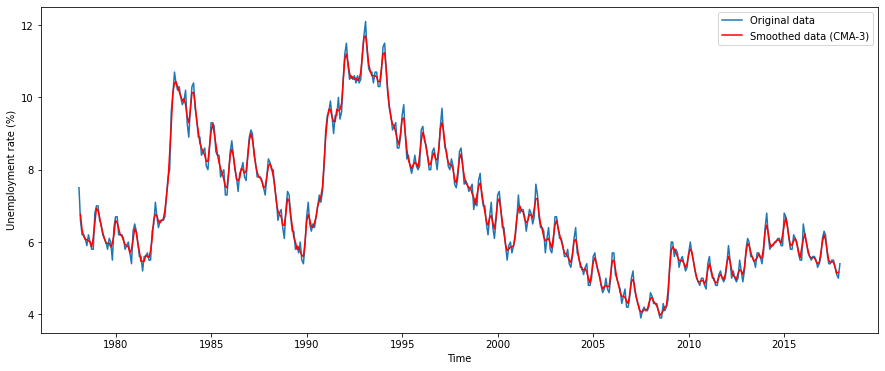

In [16]:
# Plot the original and smooth series
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(train_CMA3,'r')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend(['Original data','Smoothed data (CMA-3)'])# no smoothing
plt.savefig('MA-3')

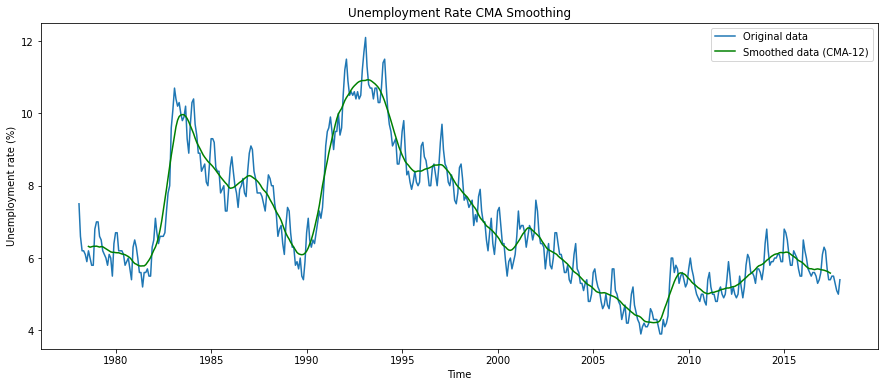

In [17]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(train_CMA12,'g')

plt.title('Unemployment Rate CMA Smoothing')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend(['Original data','Smoothed data (CMA-12)'])
plt.savefig('MA-12')

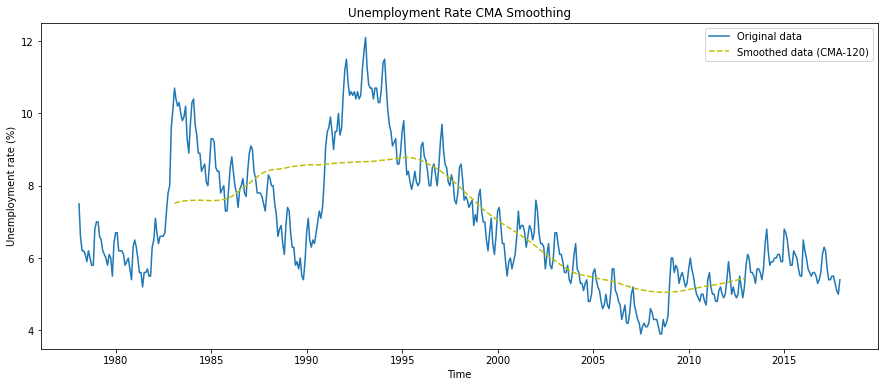

In [18]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(train_CMA120,'--y')# eliminate seasonal pattern

plt.title('Unemployment Rate CMA Smoothing')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend(['Original data','Smoothed data (CMA-120)'])
plt.savefig('MA-120')

## Time series decomposition 

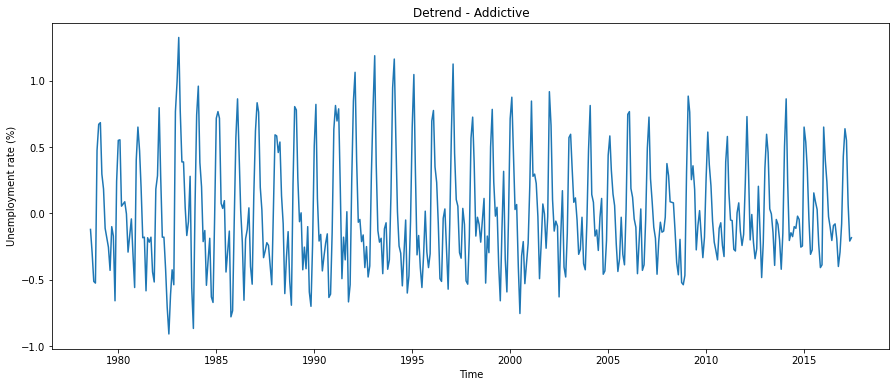

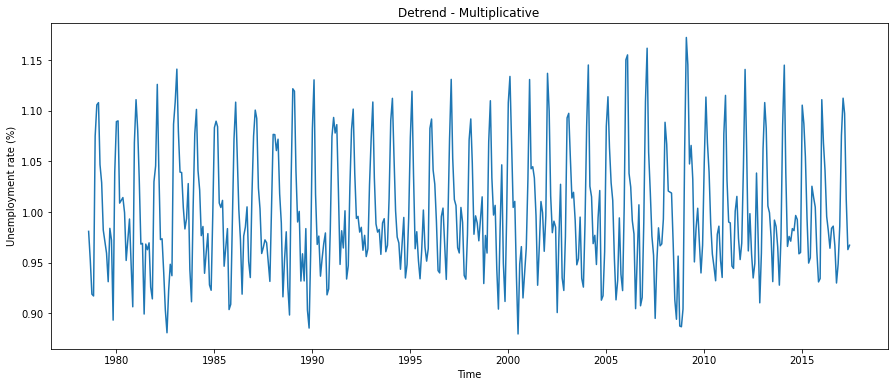

In [19]:
detrend_A = train - train_CMA12
plt.figure(figsize = (15,6))
plt.plot(detrend_A)
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.title('Detrend - Addictive')
plt.savefig('addictive')

detrend_M = train / train_CMA12
plt.figure(figsize = (15,6))
plt.plot(detrend_M)
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.title('Detrend - Multiplicative')
plt.savefig('multiplicative')

However, there is no obvious differences for the two types of detrend methods.

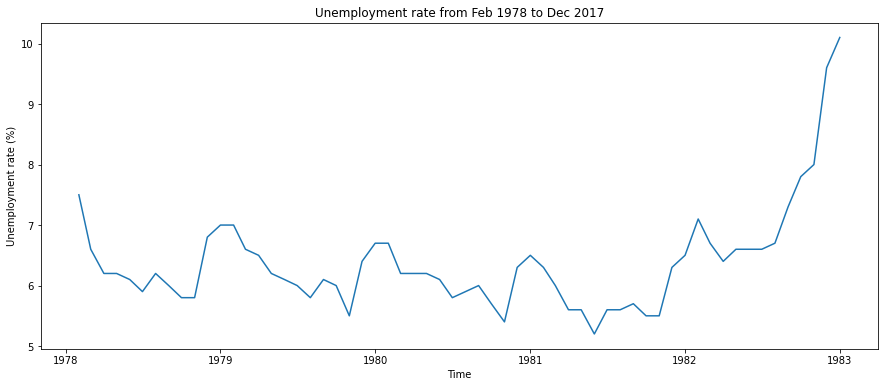

In [20]:
plt.figure(figsize = (15,6))
plt.plot(train[:60].index,train[:60])
plt.title('Unemployment rate from Feb 1978 to Dec 2017')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.savefig('check')

We can see that the seasonal variation of the time series data decreases with same seasonality but with unforseen fluctuations. If we want to use the decomposion approach to model this type of data, an addictive model is more suitable.

### Step 1: Initially estimate the trend-cycle component by moving average

In Step 1, to calculate the ***initial*** estimation trend-cycle estimate, we need to do **Moving Average** to remove the seasonal fluctuation. For example, for the series with seasonal period `M`, we should do a `CMA-M`. Denote by $\overline{T}_t$ the initial estimation for the trend-cycle component, we have:

$$
\widehat{T}_t \approx \widehat{T_t + C_t} = \text{Moving Average}(Y_t)
\tag{1}
$$

Once we decide the decomposition method, which is an addictive model, the next step is to estimate the seasonal component. For additive decomposition, we have:

$$
S_t + R_t = Y_t - (T_t+C_t)
\tag{2}
$$

Given the initial estimation for the trend-cycle component $\widehat{T}_t$, we then subtract the initial trend from the original series to obtain the de-trended series and name this series as `train_res` in the Python implementation. This `train_res` series can be seen as the approximation for the $S_t + R_t$ component in (2). In the next section, we will use this de-trend series to fine-tune the estimation for the seasonal component. 

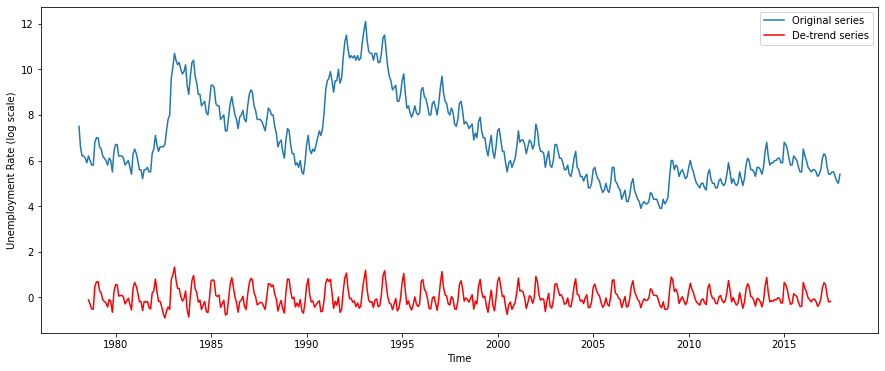

In [21]:
# Apply CMA-M with M=12 to initially estimate the trend
# Shift the new series to equalize (symmetrize) the number of missing values on both sides
Trend_init = train.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)
# Subtract the initial trend from the original series to obtaibed the de-trend series
train_res = train - Trend_init

# Plot the de-trended and original series
plt.figure(figsize = (15,6))
plt.plot(train.index,train,label="Original series")
plt.plot(train.index,train_res,'r-',label="De-trend series")
plt.xlabel('Time')
plt.ylabel('Unemployment Rate (log scale)')
plt.legend()
plt.savefig('detrend')

### Step 2: Estimate the seasonal component from the de-trend series

In [22]:
# Replace missing values in the ts_res by zeros
train_res_zero = np.nan_to_num(train_res)
print(train_res_zero.shape)

#Add '0' to amke ours dataset has 480 month data
train_0 = np.insert(train_res_zero,0,train_res_zero[0])
print(train_0.shape)

# Reshape the de-trended series to a table. 
# A column contains data in a particular month of 40 years.
# For example, column 1 contains percentage of unemployment rate in January of 40 years.
monthly_S = np.reshape(train_0, (40,12))

# Calculate column averages (Average percentage of unemployment in 12 months of 40 years)
monthly_avg = np.mean(monthly_S[1:39,:], axis=0)

monthly_avg

(479, 1)
(480,)


array([ 0.58475877,  0.7752193 ,  0.35800439,  0.05910088, -0.02675439,
       -0.22763158, -0.35953947, -0.22357456, -0.04605263, -0.38157895,
       -0.46666667, -0.0439693 ])

In [23]:
# Normalize the seasonal index
seasonal_idx = monthly_avg.mean().round(4)
seasonal_idx_normalized = monthly_avg.round(4) - seasonal_idx
print(seasonal_idx_normalized.mean())

1.1564823173178714e-17


In [24]:
# Replicate the normalized seasonal index array 40 times 
# to obtain the final estimation of the seasonal component
seasonal = np.tile(seasonal_idx_normalized, 40)

# Subtract the seasonal average from the original data 
# to obtain the seasonal adjusted data
seasonally_adjusted= train['Unemployment_Rate'] - seasonal[1:]


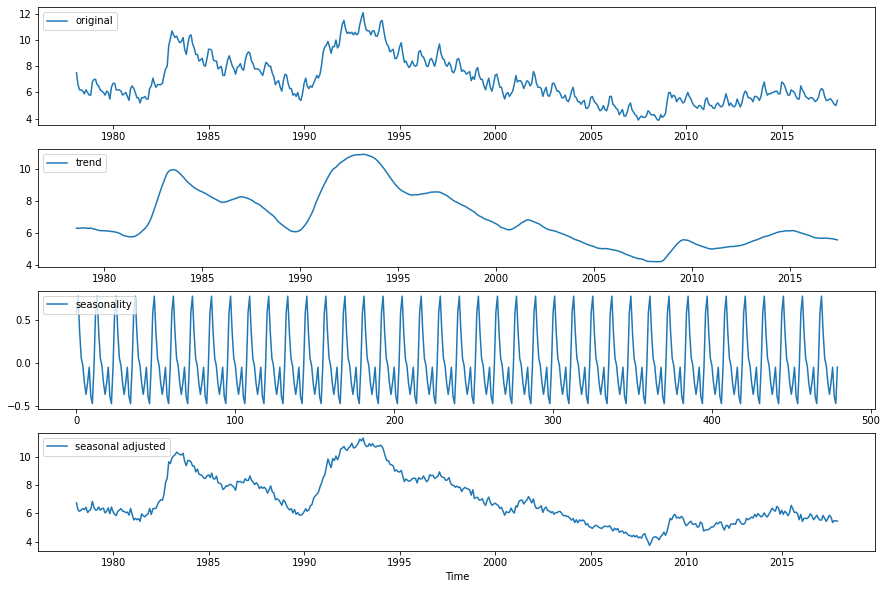

In [25]:
# Plot the seasonally adjusted data:
fig, ax = plt.subplots(4, 1,figsize=(15,10))
ax[0].plot(train)
ax[1].plot(Trend_init)
ax[2].plot(seasonal)
ax[3].plot(seasonally_adjusted)

ax[0].legend(['original'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['seasonal adjusted'], loc=2)

plt.xlabel('Time')
plt.savefig('seasonally adjusted')

## Assessing stationarity

There are useful ways to examine the stationarity of a given time series:
- **Visualisation:**
    - We can assess the stationarity of a time series by assessing its **sample ACF** plot. In general, it can be shown that for nonseasonal time series:
        - If the sample ACF of a nonseasonal time series **cuts off or dies down reasonably quickly**, then the time series should be considered it stationary.
        - If the sample ACF of a nonseasonal time series **dies down extremely slowly or not at all**, then the time series should be considered it nonstationary.
    - If the time series exhibit clear trend or seasonality, it is non-stationary (why?).

In [26]:
import statsmodels as sm
import statsmodels.api as smt

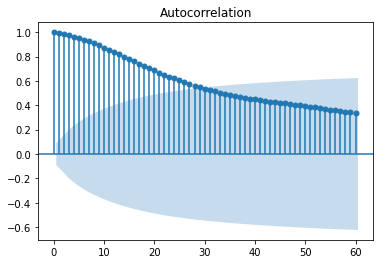

In [27]:
# Plot the sample ACF for the data. This call opens a new plot
smt.graphics.tsa.plot_acf(seasonally_adjusted, lags=60, alpha = 0.05)
plt.savefig('autocorrelation')

Can't tell cut off or die down reasonably quickly, yet, the graph shows strong relationship within the data, hence, we need further modelling to explore.

# Modeling

## Decomposition

### moving average


In [28]:
from sklearn.metrics import mean_squared_error
trend_SA = seasonally_adjusted.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)[6:-6]

trend_SA = trend_SA.tolist()
print(len(trend_SA))

467


In [29]:
for i in range(30):
    trend_SA.append(np.mean(trend_SA[-12:]))
print(len(trend_SA))
forecast_trend_1 = trend_SA[-24:]
forecast_seasonal_1 = seasonal[0:24]
forecast_decomposition_1 = forecast_trend_1+forecast_seasonal_1

497


<function matplotlib.pyplot.savefig(*args, **kwargs)>

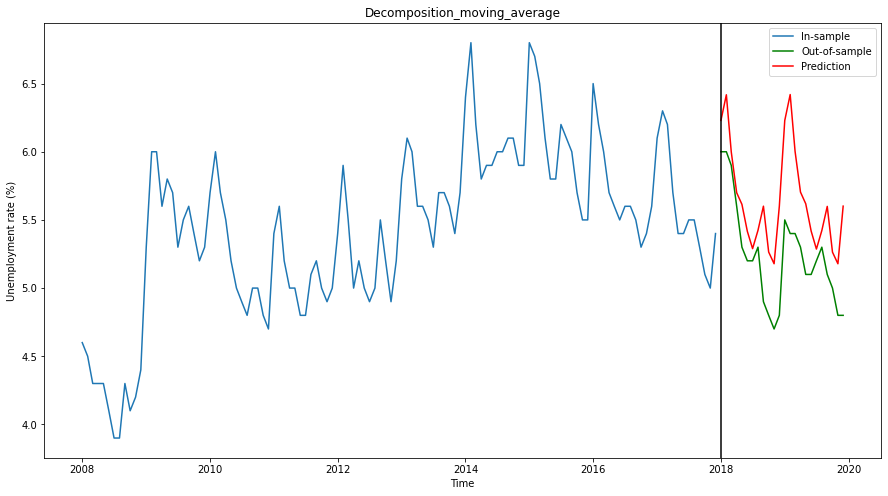

In [30]:
plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),forecast_decomposition_1,"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('Decomposition_moving_average')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.savefig

In [31]:
def RMSE(y_hat):
    return np.sqrt(mean_squared_error(test,y_hat)).round(4)


In [32]:
RMSE_decom_1 = RMSE(forecast_decomposition_1)
RMSE_decom_1

0.4824

### linear regression

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:


x = np.linspace(1, len(seasonally_adjusted), len(seasonally_adjusted)).reshape(len(seasonally_adjusted), 1)

y = seasonally_adjusted.values
 
lm = LinearRegression() 
lm.fit(x.reshape(-1, 1).astype(np.float32), y)
X_fitting = np.reshape(np.arange(len(seasonally_adjusted)), (len(seasonally_adjusted),1))
trend_linear = lm.predict(X_fitting)

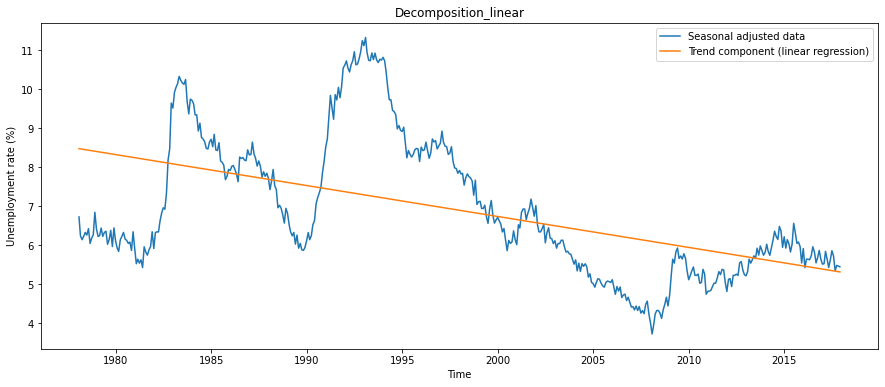

In [35]:

plt.figure(figsize=(15,6))
plt.plot(seasonally_adjusted)
plt.plot(list(train.index),trend_linear)
plt.title('Decomposition_linear')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend(['Seasonal adjusted data','Trend component (linear regression)'])
plt.show()

In [36]:
x_predict = []
for i in range(24):
    h = len(seasonally_adjusted)+i+1
    x_predict.append(h)
print(x_predict)

[480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503]


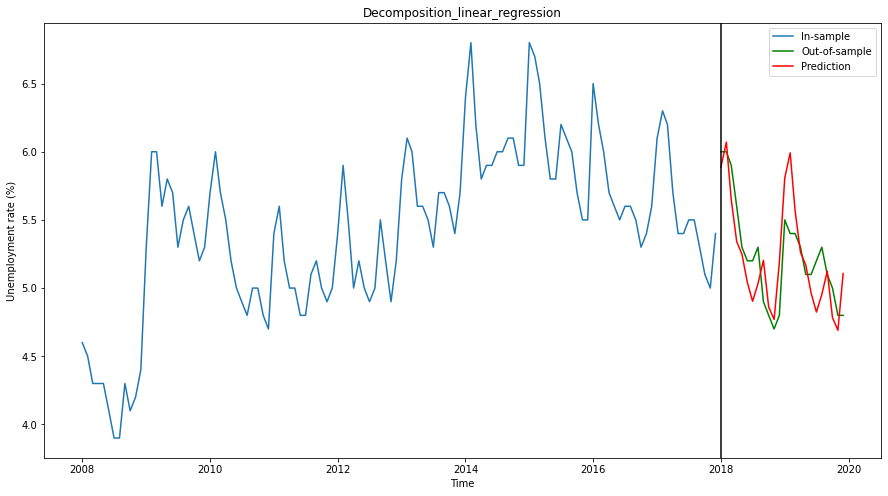

In [37]:
x_predict=np.array(x_predict).reshape(-1,1)

forecast_trend_2 = lm.predict(x_predict)
forecast_seasonal_2 = seasonal[0:24]
forecast_decomposition_2 = forecast_trend_2+forecast_seasonal_2

plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),forecast_decomposition_2,"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('Decomposition_linear_regression')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [38]:
RMSE_decom_2 = RMSE(forecast_decomposition_2)
RMSE_decom_2

0.2499

### linear regression (log)

In [39]:
Trend_init = train_log.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

# Subtract the initial trend from the original series to obtaibed the de-trend series
train_res = train_log - Trend_init
# Replace missing values in the ts_res by zeros
# Replace missing values in the ts_res by zeros
train_res_zero = np.nan_to_num(train_res)
print(train_res_zero.shape)

#Add '0' to amke ours dataset has 480 month data
train_res_zero = np.insert(train_res_zero,0,train_res_zero[0])
print(train_res_zero.shape)

# Reshape the de-trended series to a table. 
# A column contains data in a particular month of 40 years.
# For example, column 1 contains percentage of unemployment rate in January of 40 years.
monthly_S = np.reshape(train_res_zero, (40,12))

# Calculate column averages (Average percentage of unemployment in 12 months of 40 years)
monthly_avg = np.mean(monthly_S[1:39,:], axis=0)

seasonal_idx = monthly_avg.mean().round(4)
seasonal_idx_normalized = monthly_avg.round(4) - seasonal_idx

seasonal = np.tile(seasonal_idx_normalized, 40)
seasonally_adjusted_log= train_log - seasonal[1:]

(479,)
(480,)


In [40]:
x = np.linspace(1, len(seasonally_adjusted_log), len(seasonally_adjusted_log)).reshape(len(seasonally_adjusted_log), 1)

y = seasonally_adjusted_log.values
 
lm = LinearRegression() 
lm.fit(x.reshape(-1, 1).astype(np.float32), y)
X_fitting = np.reshape(np.arange(len(seasonally_adjusted_log)), (len(seasonally_adjusted_log),1))
trend_linear_log = lm.predict(X_fitting)

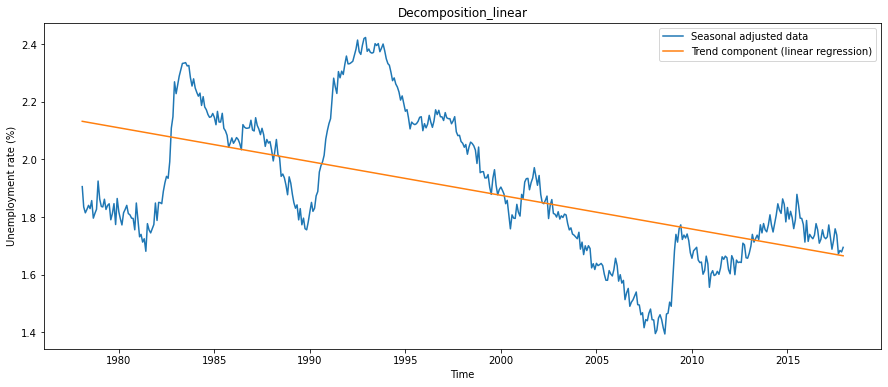

In [41]:
plt.figure(figsize=(15,6))
plt.plot(seasonally_adjusted_log)
plt.plot(list(train.index),trend_linear_log)
plt.title('Decomposition_linear')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend(['Seasonal adjusted data','Trend component (linear regression)'])
plt.show()

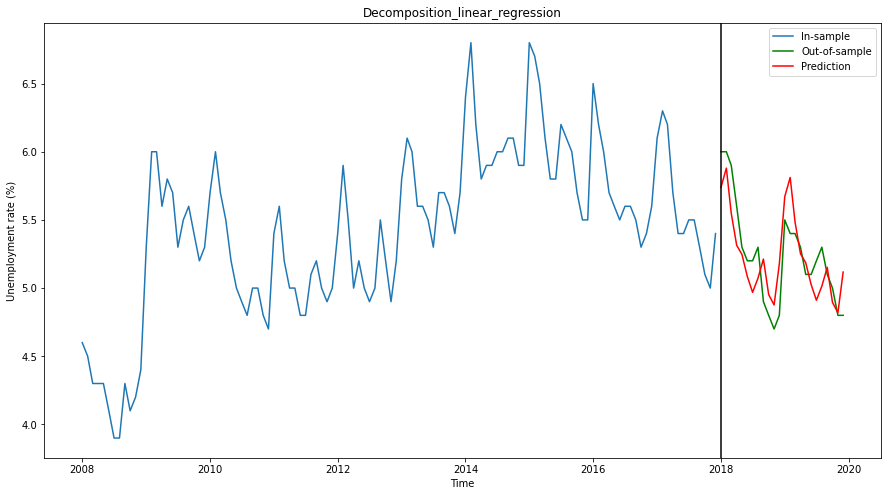

In [42]:
x_predict=np.array(x_predict).reshape(-1,1)

forecast_trend_log = lm.predict(x_predict)
forecast_seasonal_log = seasonal[0:24]
forecast_decomposition_log = forecast_trend_log+forecast_seasonal_log

plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),np.exp(forecast_decomposition_log),"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('Decomposition_linear_regression')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [43]:
RMSE_decom_log = RMSE(np.exp(forecast_decomposition_log))
RMSE_decom_log

0.2242

## Drift Method

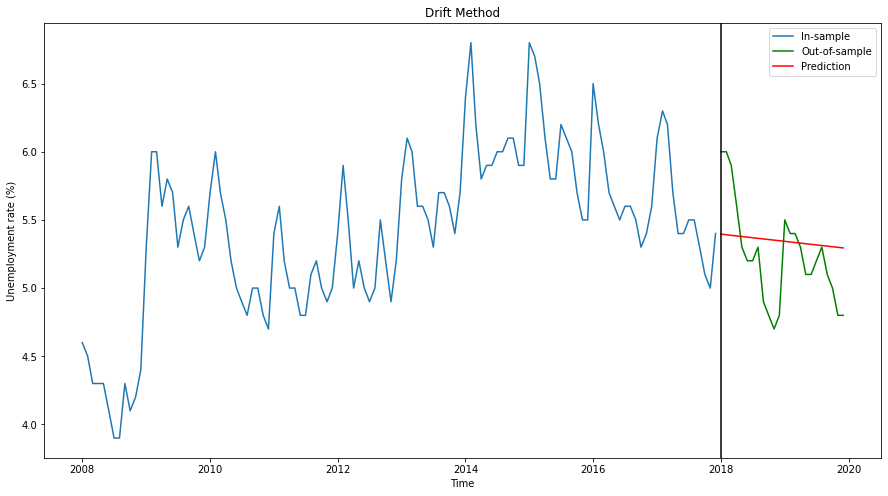

In [44]:
yt = train['Unemployment_Rate'][-1]
y1 = train['Unemployment_Rate'][0]
forecast_drift= []
for h in range(1,25):
    forecast_drift.append(yt+h*((yt-y1)/(len(train)-1)))

plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),forecast_drift,"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('Drift Method')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [45]:
RMSE_drift = RMSE(forecast_drift)
RMSE_drift

0.3615

## Holt-Winter Method

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
y = train['Unemployment_Rate']
fit_add = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
fit_mul = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative smoothing

d:\program files (x86)\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
d:\program files (x86)\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [47]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
results["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]
print(results)

           Additive  Multiplicative
$\alpha$   0.684823    8.626714e-01
$\beta$    0.168658    5.690977e-12
$\gamma$   0.187504    1.369583e-01
$l_0$      7.837044    7.543266e+00
$b_0$     -0.033908   -4.493130e-03
SSE       24.578425    2.438202e+01


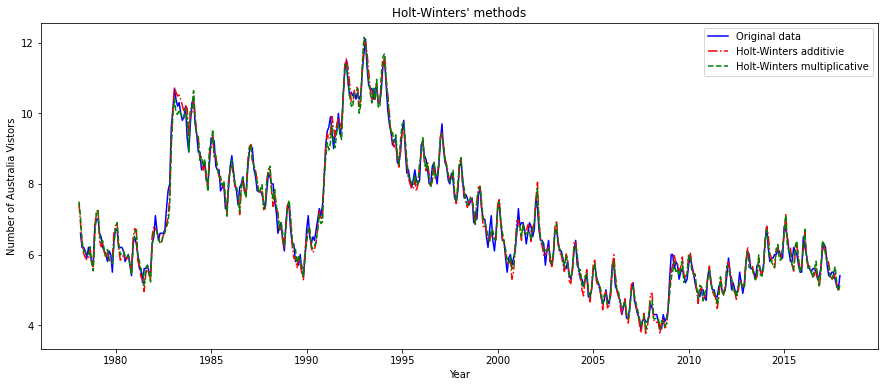

In [48]:
smooth_add = fit_add.fittedvalues
smooth_mul = fit_mul.fittedvalues

plt.figure(figsize=(15,6))
plt.plot(y[1:], 'b-', label = 'Original data')
plt.plot(smooth_add, 'r-.',label = 'Holt-Winters additivie')
plt.plot(smooth_mul, 'g--', label = 'Holt-Winters multiplicative')
plt.xlabel("Year")
plt.ylabel("Number of Australia Vistors")
plt.title("Holt-Winters' methods")
plt.legend()
plt.show()

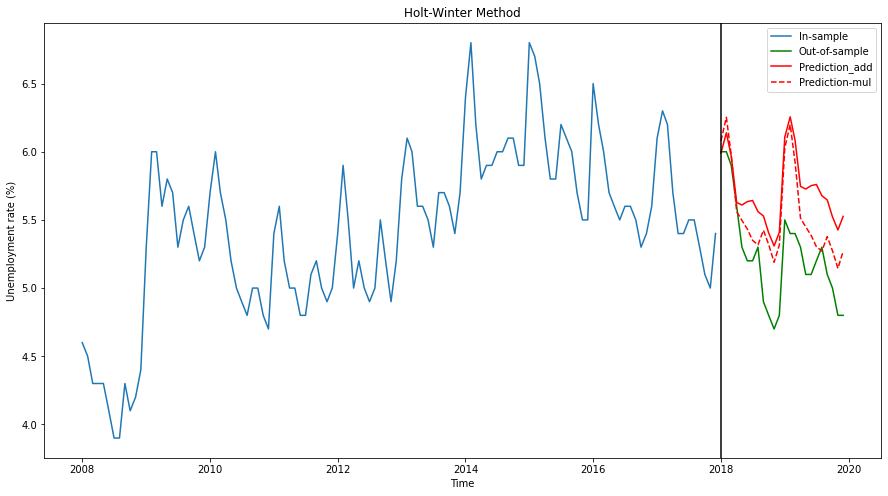

In [49]:
y_forecast_add = fit_add.forecast(24)
y_forecast_mul = fit_mul.forecast(24)
plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),y_forecast_add,"r",label = "Prediction_add")
plt.plot(list(test.index),y_forecast_mul,"--r",label = "Prediction-mul")
plt.axvline(x=test.index[0],color = "black")
plt.title('Holt-Winter Method')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [50]:
RMSE_HWS_add = RMSE(y_forecast_add)
RMSE_HWS_mul = RMSE(y_forecast_mul)
print(RMSE_HWS_add)
print(RMSE_HWS_mul)

0.5247
0.3643


## SARIMA

In [51]:
import statsmodels as sm
import statsmodels.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

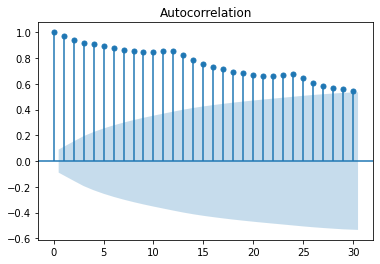

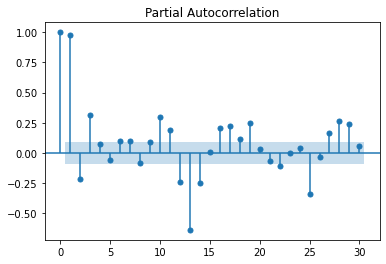

In [52]:


smt.graphics.tsa.plot_acf(train_log, lags=30, alpha = 0.05)
plt.show()
smt.graphics.tsa.plot_pacf(train_log, lags=30, alpha = 0.05)
plt.show()

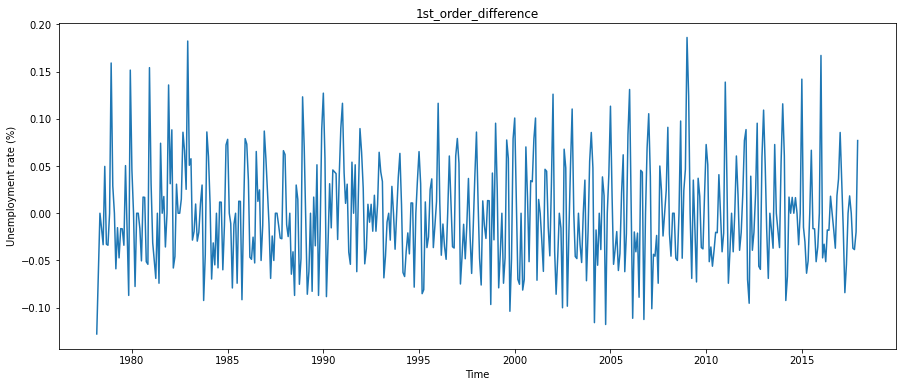

In [53]:
train_log_diff = train_log - train_log.shift()
train_log_diff.dropna(inplace = True)
plt.figure(figsize = (15,6))
plt.plot(train_log_diff)
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.title('1st_order_difference')
plt.show()


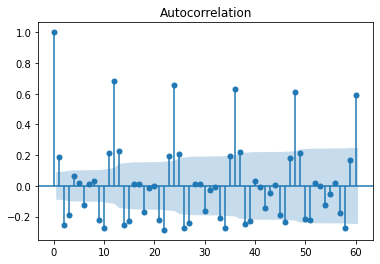

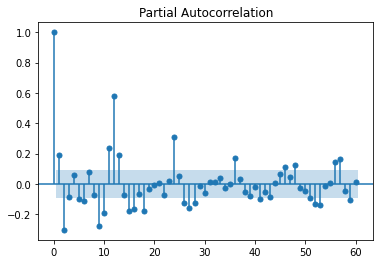

In [54]:
smt.graphics.tsa.plot_acf(train_log_diff, lags=60, alpha = 0.05)
plt.show()

smt.graphics.tsa.plot_pacf(train_log_diff, lags=60, alpha = 0.05)
plt.show()

p 3
d 1
q 4 OR 3

P 1
D 1
Q 0

In [55]:
model = SARIMAX(train_log, 
                order = (3,1,4),                 # Non-seasonal component
                seasonal_order = (2,1,0,12),     # Seasonal component
                enforce_stationarity = False,
                enforce_invertibility = False)

# Fit the SARIMAX model on in-sample data
model_fit = model.fit()

# Forecast the number of passengers for the out-of-sample period
forecast_SARIMA = np.exp(model_fit.forecast(len(test)))

d:\program files (x86)\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
d:\program files (x86)\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
d:\program files (x86)\python\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


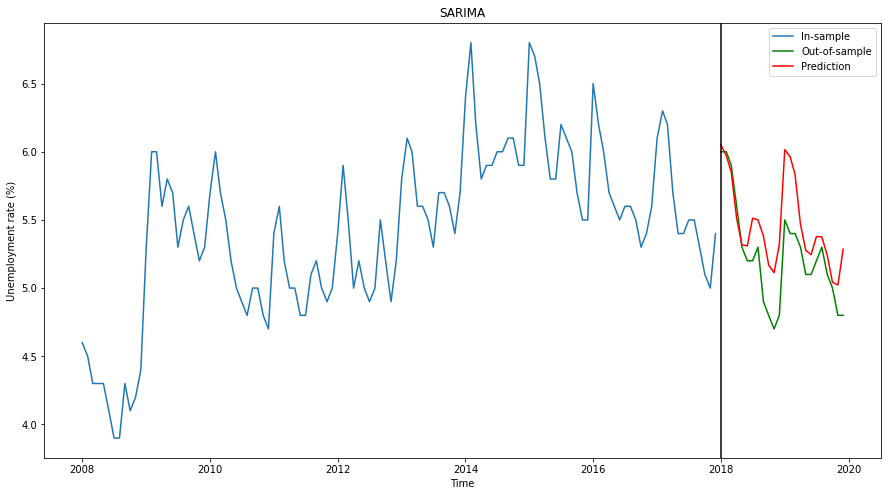

In [56]:
plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),forecast_SARIMA,"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('SARIMA')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [57]:
RMSE_SARIMA = RMSE(forecast_SARIMA)
RMSE_SARIMA

0.3003

## NN

In [58]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [59]:

data_not_scaled = train.values          # Convert from DataFrame to Python Array
data_not_scaled = data_not_scaled.astype('float') # You need to make sure the data is type of float


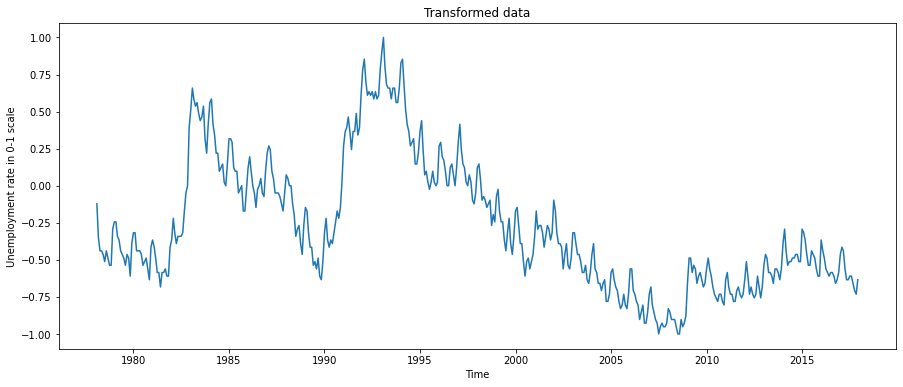

In [60]:
from sklearn.preprocessing import MinMaxScaler

time_window = 15

# Define a scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Compute in-sample and out-of-sample size
train_size = len(data_not_scaled)-time_window
test_size = 24

# Fitting the scaler
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])

# Transforming using trained scaler
data_scaled = fitted_transformer.transform(data_not_scaled)

# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(train.index,data_scaled)
plt.xlabel('Time')
plt.ylabel('Unemployment rate in 0-1 scale')
plt.title('Transformed data')
plt.show()

In [61]:
# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0])
    Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0])
    Yall.append(data_scaled[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [62]:
model = Sequential()
model.add(Dense(10, input_dim = time_window, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1))

In [63]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [64]:
model.fit(Xtrain, Ytrain, epochs=250, batch_size=20 , verbose=1)

Epoch 1/250
24/24 [==============================] - 0s 739us/step - loss: 0.1534
Epoch 2/250
24/24 [==============================] - 0s 652us/step - loss: 0.0509
Epoch 3/250
24/24 [==============================] - 0s 652us/step - loss: 0.0353
Epoch 4/250
24/24 [==============================] - 0s 652us/step - loss: 0.0327
Epoch 5/250
24/24 [==============================] - 0s 696us/step - loss: 0.0303
Epoch 6/250
24/24 [==============================] - 0s 565us/step - loss: 0.0283
Epoch 7/250
24/24 [==============================] - 0s 652us/step - loss: 0.0266
Epoch 8/250
24/24 [==============================] - 0s 609us/step - loss: 0.0250
Epoch 9/250
24/24 [==============================] - 0s 609us/step - loss: 0.0234
Epoch 10/250
24/24 [==============================] - 0s 783us/step - loss: 0.0220
Epoch 11/250
24/24 [==============================] - 0s 696us/step - loss: 0.0208
Epoch 12/250
24/24 [==============================] - 0s 652us/step - loss: 0.0199
Epoch 13/250


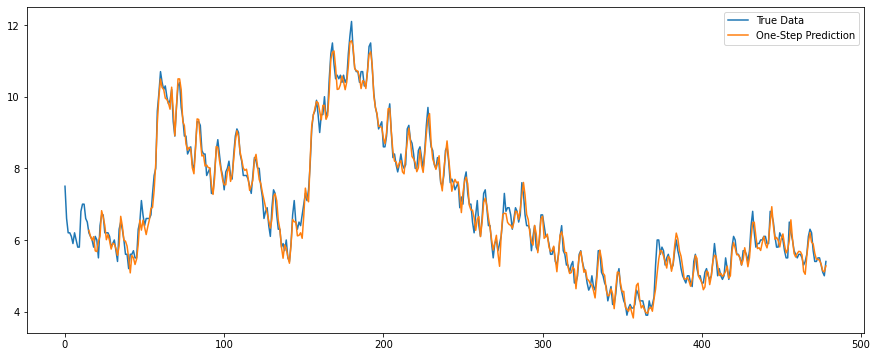

In [65]:
allPredict = model.predict(np.reshape(Xall, (Xall.shape[0],time_window)))
allPredict_original_scale = scaler.inverse_transform(allPredict)
allPredictPlot = np.empty_like(data_scaled)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_window:, :] = allPredict_original_scale

# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction')
plt.legend()
plt.show()

In [66]:
dynamic_prediction = np.copy(data_scaled[:len(data_scaled)])

for i in range(len(data_scaled), len(data_scaled)+24):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)
forecast_nn = dynamic_prediction_original_scale[-24:]

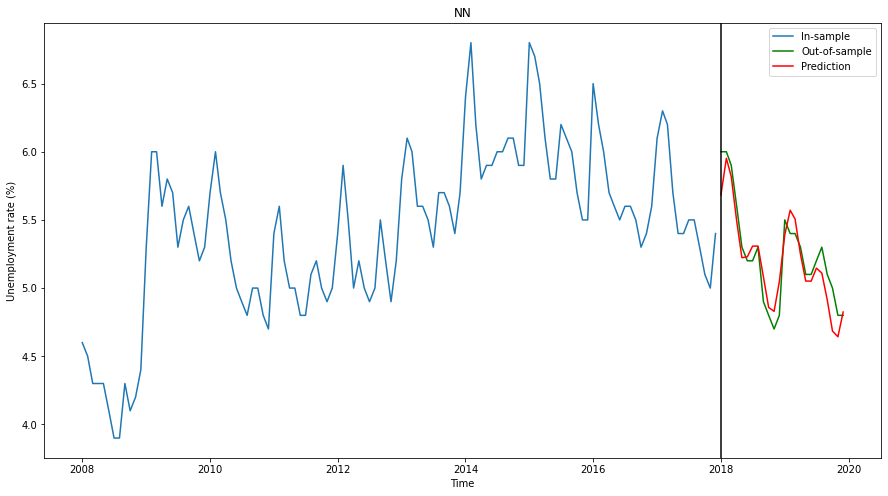

In [67]:
plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),forecast_nn,"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('NN')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [68]:
RMSE_nn = RMSE(forecast_nn)
RMSE_nn

0.1461

## LSTM

In [69]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential
np.random.seed(0)
tf.random.set_seed(0)

In [70]:
data_not_scaled = train.values          # Convert from DataFrame to Python Array
data_not_scaled = data_not_scaled.astype('float') # You need to make sure the data is type of float

In [71]:
time_window = 13

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute in-sample and out-of-sample size
train_size = len(data_not_scaled)-time_window
test_size = 24

# Fitting the scaler
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])

# Transforming using trained scaler
data_scaled = fitted_transformer.transform(data_not_scaled)


In [72]:
# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0])
    Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0])
    Yall.append(data_scaled[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [73]:
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window,1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], time_window,1))

In [74]:
model = Sequential()
model.add(LSTM(units=20,input_shape = (time_window,1))) 
model.add(Dense(units=1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [76]:
model.fit(Xtrain, Ytrain, 
          batch_size = 20,             
          epochs = 300,               
          validation_split = 0.05, 
          shuffle = False,
          verbose = 1, 
          callbacks = [early_stop])

Epoch 1/300
23/23 [==============================] - 1s 17ms/step - loss: 0.0718 - val_loss: 0.0023
Epoch 2/300
23/23 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.0106
Epoch 3/300
23/23 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 4/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0042
Epoch 5/300
23/23 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0029
Epoch 6/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 7/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 8/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 9/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 10/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 11

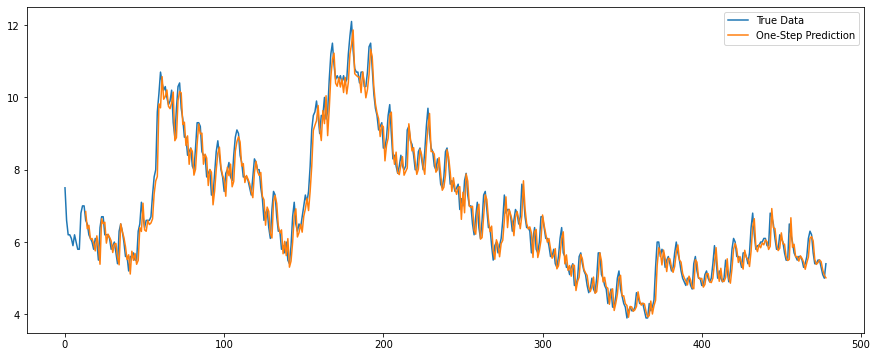

In [77]:
allPredict = model.predict(np.reshape(Xall, (Xall.shape[0],time_window,1)))
allPredict_original_scale = scaler.inverse_transform(allPredict)
allPredictPlot = np.empty_like(data_scaled)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_window:, :] = allPredict_original_scale

# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction')
plt.legend()
plt.show()

In [78]:
dynamic_prediction = np.copy(data_scaled[:len(data_scaled)])

for i in range(len(data_scaled), len(data_scaled)+24):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale_1 = scaler.inverse_transform(dynamic_prediction)
forecast_LSTM = dynamic_prediction_original_scale_1[-24:]

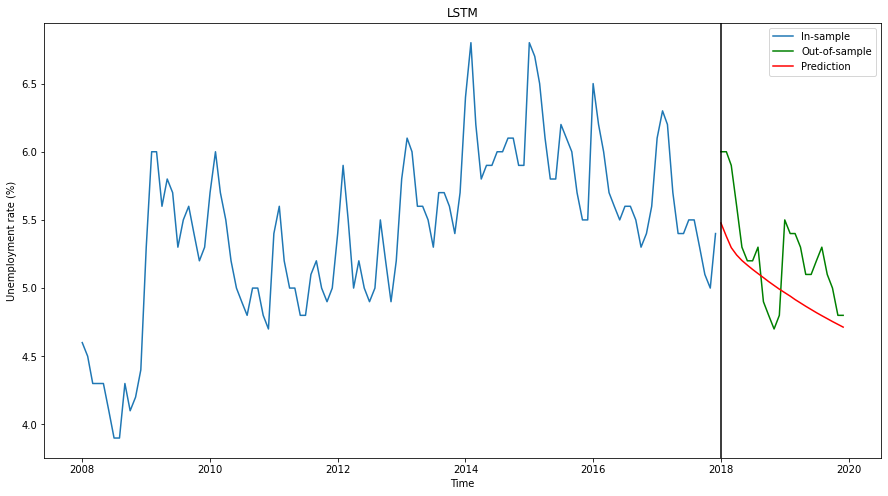

In [79]:
plt.figure(figsize=(15,8))
plt.plot(train[-120:],label ="In-sample")
plt.plot(test,"g",label = "Out-of-sample")
plt.plot(list(test.index),forecast_LSTM,"r",label = "Prediction")
plt.axvline(x=test.index[0],color = "black")
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Unemployment rate (%)')
plt.legend()
plt.show()

In [80]:
RMSE_LSTM = RMSE(forecast_LSTM)
RMSE_LSTM

0.3551

# RMSE

In [81]:
RMSE = [RMSE_decom_1,
RMSE_decom_2,
RMSE_decom_log,
RMSE_drift,
RMSE_HWS_add,
RMSE_HWS_mul,
RMSE_SARIMA,
RMSE_nn,
RMSE_LSTM]
NAME = ['Decomposition_moving_avg','Decomposition_add_linear','Decomposition_log_linear',
        'Drift','Holt-Winter-add','Holt-Winter-mul','SARIMA','NN','LSTM']
       
TABLE = pd.DataFrame(RMSE,index =NAME,columns = ['RMSE'] )
TABLE.sort_values(['RMSE'])

,RMSE
NN,0.1461
Decomposition_log_linear,0.2242
Decomposition_add_linear,0.2499
SARIMA,0.3003
LSTM,0.3551
Drift,0.3615
Holt-Winter-mul,0.3643
Decomposition_moving_avg,0.4824
Holt-Winter-add,0.5247
